In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
COLORS = sns.color_palette('hls',6)

# Analysing Nashville Policing Activity with Pandas

Using data from **https://openpolicing.stanford.edu/data/** I will be exploring, cleaning and then analysing it to answer interesting questions about it.

The steps and questions are:

* Prepare the data for analysis
  * EDA
  * Drop columns & rows
  * Fix data
  * Creating a Datetime index

* Questions that you will try to answer:
  * Do men or women speed more often?
  * Does gender affect who gets searched during a stop?
  * Does gender affect whose vehicle is searched?
  * During a search, how often is the driver frisked?
  * Which year had the least number of stops?
  * Does time of the day affect arrest rate?
  * How does drug activity change by time of day?
  * Do most stops occur at night?
  * Analyse the effect of weather

# Loading in the Nashville Dataset

In [3]:
df = pd.read_csv('tn_nashville_2020_04_01.csv')

C:\Users\Coach\AppData\Local\Temp\ipykernel_17596\1498399592.py:1: DtypeWarning: Columns (6,8,15,16,17,22,23,24,25,29,30,31,32,33,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tn_nashville_2020_04_01.csv')


In [4]:
df.head()

,raw_row_number,date,time,location,lat,lng,precinct,reporting_area,zone,subject_age,...,raw_traffic_citation_issued,raw_misd_state_citation_issued,raw_suspect_ethnicity,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view
0,232947,2010-10-10,NaN,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...",36.187925,-86.798519,6.0,4403.0,611.0,27.0,...,False,NaN,N,False,False,False,False,False,False,False
1,237161,2010-10-10,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5.0,9035.0,513.0,18.0,...,True,NaN,N,False,False,False,False,False,False,False
2,232902,2010-10-10,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1.0,5005.0,121.0,52.0,...,False,NaN,N,False,False,False,False,False,False,False
3,233219,2010-10-10,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3.0,8891.0,325.0,25.0,...,False,NaN,N,False,False,False,False,False,False,False
4,232780,2010-10-10,01:00:00,"BUCHANAN ST, NORTH, TN, 37208",36.180038,-86.809109,NaN,NaN,NaN,21.0,...,False,NaN,N,True,True,False,False,False,False,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3092351 entries, 0 to 3092350
Data columns (total 42 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   raw_row_number                  object 
 1   date                            object 
 2   time                            object 
 3   location                        object 
 4   lat                             float64
 5   lng                             float64
 6   precinct                        object 
 7   reporting_area                  float64
 8   zone                            object 
 9   subject_age                     float64
 10  subject_race                    object 
 11  subject_sex                     object 
 12  officer_id_hash                 object 
 13  type                            object 
 14  violation                       object 
 15  arrest_made                     object 
 16  citation_issued                 object 
 17  warning_issued             

# Checking Missing Values

In [6]:
df[df.columns].isnull().sum().sort_values(ascending=False)/len(df)

contraband_weapons                9.587029e-01
search_basis                      9.587029e-01
contraband_found                  9.587029e-01
contraband_drugs                  9.587029e-01
notes                             8.342184e-01
raw_misd_state_citation_issued    2.243646e-01
raw_written_warning_issued        1.594551e-01
precinct                          1.261894e-01
zone                              1.261894e-01
reporting_area                    1.074888e-01
lng                               6.050607e-02
lat                               6.050607e-02
vehicle_registration_state        1.028053e-02
subject_sex                       4.146360e-03
violation                         2.593496e-03
reason_for_stop                   2.593496e-03
time                              1.767911e-03
outcome                           6.257375e-04
subject_race                      5.982503e-04
subject_age                       2.713146e-04
raw_verbal_warning_issued         1.089786e-04
warning_issue

### Contraband Columns

* Contraband is only recorded as found or not if the search has been conducted
* Replace NaNs with string "Not Searched"

In [7]:
lst = ['contraband_weapons','search_basis','contraband_found','contraband_drugs']
df[lst] = df[lst].fillna("Not Searched")

### Notes Column

* Can fill NaNs with a string saying "No Notes Taken."

In [8]:
df['notes'] = df['notes'].fillna("No Notes Taken")

### Warning and Citation Columns

* The Stanford README notes state that they assume NaN to be False in these columns so I will do the same

In [9]:
lst = ["raw_misd_state_citation_issued", "raw_written_warning_issued", "raw_verbal_warning_issued",
         "warning_issued", "raw_traffic_citation_issued","citation_issued"]
df[lst] = df[lst].fillna(False)

### Precinct, Zone and Reporting Area Columns

* All these columns already have an unknown string being used, so we can replace NaNs with that.

In [10]:
df["precinct"] = df["precinct"].fillna("U")
df["zone"] = df["zone"].fillna("UNK")
df["reporting_area"] = df["reporting_area"].fillna("UNK")

### Longitude and Latitude

* We will interpolate the coordinates to replace the missing values.

In [11]:
df["lng"] = df["lng"].interpolate(method='linear')
df["lat"] = df["lat"].interpolate(method='linear')

### Vehicle Registration State, Subject Sex, Violation, Reason for Stop, Subject Race

* For these we can simply replace NaN with an unknown value string

In [12]:
lst = ["vehicle_registration_state","subject_sex","violation","reason_for_stop","subject_race","outcome"]
df[lst] = df[lst].fillna("UNKNOWN")

### Subject Age

* For this column I will replace NaNs with the average age

In [13]:
df["subject_age"] = df["subject_age"].fillna(df["subject_age"].mean())

### Raw suspect ethnicity

* Drop this column as the raw information of ethnicity in this column we will not be using

In [14]:
df.drop(["raw_suspect_ethnicity"],axis=1,inplace=True)

### Rest of the columns with missing data

* Drop the rows which contain missing values
* Individually the each variable has about 10 - 40 rows of missing data, and many of these overlap, so out of ~3,000,000, not much is being lost

In [15]:
lst = ["search_vehicle","search_person","search_conducted","raw_driver_searched","arrest_made",
         "frisk_performed","raw_search_consent","raw_search_arrest","officer_id_hash","raw_passenger_searched",
         "raw_search_plain_view","raw_search_inventory"]
df.dropna(subset=lst,inplace=True)

# Fixing datatypes

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3092271 entries, 0 to 3092350
Data columns (total 41 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   raw_row_number                  object 
 1   date                            object 
 2   time                            object 
 3   location                        object 
 4   lat                             float64
 5   lng                             float64
 6   precinct                        object 
 7   reporting_area                  object 
 8   zone                            object 
 9   subject_age                     float64
 10  subject_race                    object 
 11  subject_sex                     object 
 12  officer_id_hash                 object 
 13  type                            object 
 14  violation                       object 
 15  arrest_made                     object 
 16  citation_issued                 bool   
 17  warning_issued             

In [17]:
df.head()

C:\Users\Coach\Desktop\Sparta\SpartaGlobal210\Data_Engineering\venv\lib\site-packages\IPython\lib\pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
C:\Users\Coach\Desktop\Sparta\SpartaGlobal210\Data_Engineering\venv\lib\site-packages\IPython\core\formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,raw_row_number,date,time,location,lat,lng,precinct,reporting_area,zone,subject_age,...,raw_written_warning_issued,raw_traffic_citation_issued,raw_misd_state_citation_issued,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view
0,232947,2010-10-10,NaN,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...",36.187925,-86.798519,6.0,4403.0,611.0,27.0,...,False,False,False,False,False,False,False,False,False,False
1,237161,2010-10-10,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5.0,9035.0,513.0,18.0,...,False,True,False,False,False,False,False,False,False,False
2,232902,2010-10-10,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1.0,5005.0,121.0,52.0,...,False,False,False,False,False,False,False,False,False,False
3,233219,2010-10-10,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3.0,8891.0,325.0,25.0,...,False,False,False,False,False,False,False,False,False,False
4,232780,2010-10-10,01:00:00,"BUCHANAN ST, NORTH, TN, 37208",36.180038,-86.809109,U,UNK,UNK,21.0,...,False,False,False,True,True,False,False,False,False,False


### Fixing Date column to make if datetime

In [18]:
df['date'] = pd.to_datetime(df['date'])

### Fixing many boolean columns which were not set as boolean before

In [19]:
lst = ['arrest_made','frisk_performed','search_conducted','search_person','search_vehicle','raw_verbal_warning_issued',
         'raw_written_warning_issued','raw_traffic_citation_issued','raw_misd_state_citation_issued','raw_driver_searched',
         'raw_passenger_searched','raw_search_consent','raw_search_arrest','raw_search_warrant','raw_search_inventory','raw_search_plain_view']
df[lst] = df[lst].astype('bool')

# Setting Date as Index

In [20]:
df.set_index('date', inplace=True)

In [21]:
df.head()

,raw_row_number,time,location,lat,lng,precinct,reporting_area,zone,subject_age,subject_race,...,raw_written_warning_issued,raw_traffic_citation_issued,raw_misd_state_citation_issued,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view
date,,,,,,,,,,,,,,,,,,,,,
2010-10-10,232947,NaN,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...",36.187925,-86.798519,6.0,4403.0,611.0,27.0,black,...,False,False,False,False,False,False,False,False,False,False
2010-10-10,237161,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5.0,9035.0,513.0,18.0,white,...,False,True,False,False,False,False,False,False,False,False
2010-10-10,232902,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1.0,5005.0,121.0,52.0,white,...,False,False,False,False,False,False,False,False,False,False
2010-10-10,233219,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3.0,8891.0,325.0,25.0,white,...,False,False,False,False,False,False,False,False,False,False
2010-10-10,232780,01:00:00,"BUCHANAN ST, NORTH, TN, 37208",36.180038,-86.809109,U,UNK,UNK,21.0,black,...,False,False,False,True,True,False,False,False,False,False


# Analysis Questions

## Do Men or Women speed more often?

* There is no specific speeding violation variable which we can use. The closest we can get it 'Moving Traffic Violation', which is what speeding should be categorised as. However other violations can also be categorised as this.

* We will create two plots one based of this moving traffic violation, and another where speeding or mph is specifically mentioned in the officer notes, that way we can be more sure that we are analysing speeding in particular.

In [36]:
pivot = pd.pivot_table(df, columns='subject_sex',values='violation',aggfunc= lambda x: (x == 'moving traffic violation').sum()).drop(columns='UNKNOWN')
pivot

subject_sex,female,male
violation,632998,907863


<Axes: >

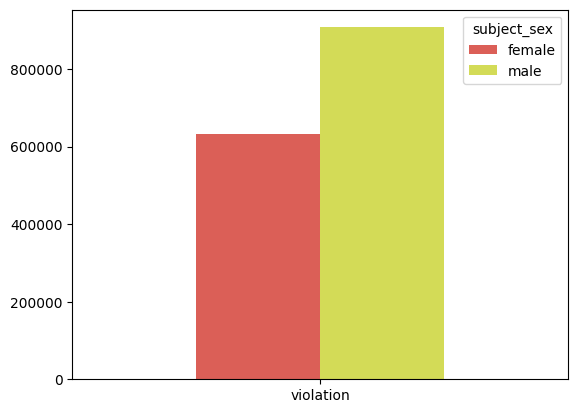

In [37]:
pivot.plot(kind='bar',rot=0,color=COLORS)

Checking notes for speed and mph

In [38]:
speeding_table = df[df['notes'].str.contains("SPEED|-- MPH|-- mph|--mph|--MPH")]
pivot = pd.pivot_table(speeding_table, columns='subject_sex',values='violation',aggfunc= lambda x: (x == 'moving traffic violation').sum()).drop(columns='UNKNOWN')
pivot

subject_sex,female,male
violation,26993,37954


<Axes: >

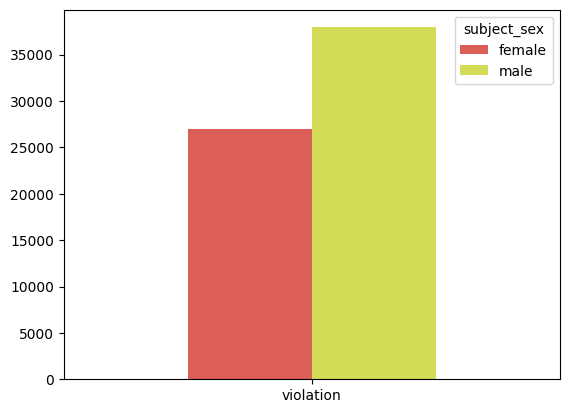

In [39]:
pivot.plot(kind='bar',rot=0,color=COLORS)

## Does gender affect the likelihood of getting searched when stopped?

### Checking Gender against if their person was searched

subject_sex    female   male
search_person   19847  81218


<Axes: >

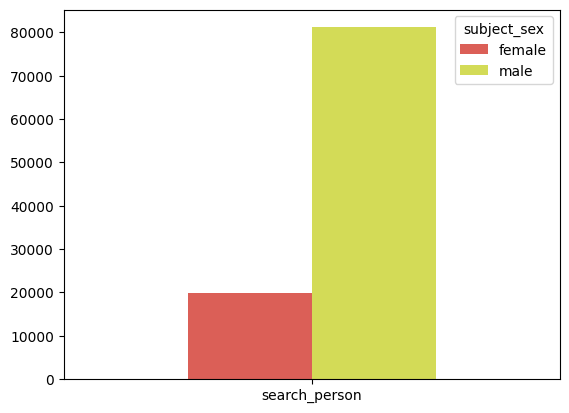

In [34]:
pivot = pd.pivot_table(df, columns='subject_sex',values='search_person',aggfunc= lambda x: (x == True).sum()).drop(columns='UNKNOWN')
print(pivot)
pivot.plot(kind='bar',rot=0,color=COLORS)

### Checking Gender against if their vehicle was searched

subject_sex     female   male
search_vehicle   23472  76649


<Axes: >

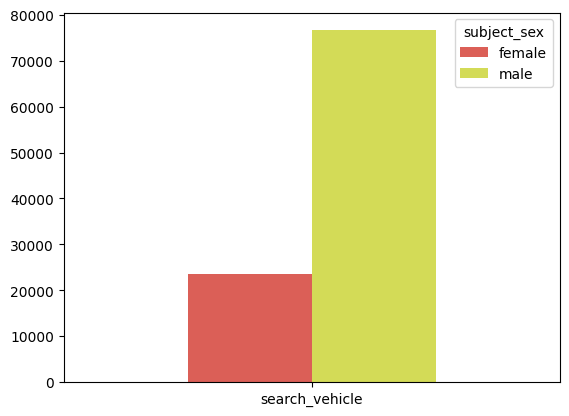

In [33]:
pivot = pd.pivot_table(df, columns='subject_sex',values='search_vehicle',aggfunc= lambda x: (x == True).sum()).drop(columns='UNKNOWN')
print(pivot)
pivot.plot(kind='bar',rot=0,color=COLORS)

# During a search, how likely is the driver to be frisked?

In [28]:
df.head()

,raw_row_number,time,location,lat,lng,precinct,reporting_area,zone,subject_age,subject_race,...,raw_written_warning_issued,raw_traffic_citation_issued,raw_misd_state_citation_issued,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view
date,,,,,,,,,,,,,,,,,,,,,
2010-10-10,232947,NaN,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...",36.187925,-86.798519,6.0,4403.0,611.0,27.0,black,...,False,False,False,False,False,False,False,False,False,False
2010-10-10,237161,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5.0,9035.0,513.0,18.0,white,...,False,True,False,False,False,False,False,False,False,False
2010-10-10,232902,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1.0,5005.0,121.0,52.0,white,...,False,False,False,False,False,False,False,False,False,False
2010-10-10,233219,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3.0,8891.0,325.0,25.0,white,...,False,False,False,False,False,False,False,False,False,False
2010-10-10,232780,01:00:00,"BUCHANAN ST, NORTH, TN, 37208",36.180038,-86.809109,U,UNK,UNK,21.0,black,...,False,False,False,True,True,False,False,False,False,False


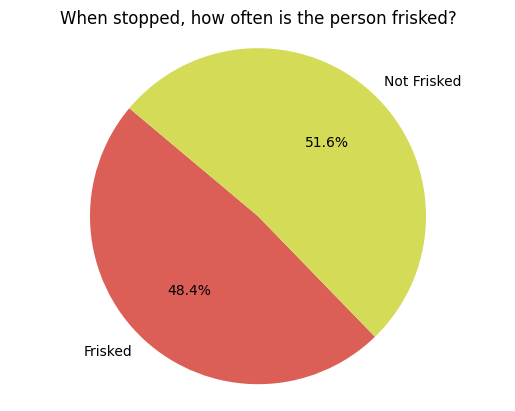

In [30]:
frisked = len(df[(df['search_conducted'] == True) & (df['frisk_performed'] == True)])
not_frisked = len(df[(df['search_conducted'] == True) & (df['frisk_performed'] == False)])
labels = ['Frisked', 'Not Frisked']
sizes = [frisked, not_frisked]
plt.pie(sizes, labels=labels,
        autopct='%1.1f%%', startangle=140, colors=COLORS)
plt.axis('equal')
plt.title('When stopped, how often is the person frisked?')
plt.show()

## Which Year had the least number of stops

* Grouping by Year, then counting rows per year
* Dataset goes from 2010-01-01 to 2019-03-24, so removing 2019 data as it is not representative of the full year

date
2010-12-31    310608
2011-12-31    393245
2012-12-31    444134
2013-12-31    412689
2014-12-31    413100
2015-12-31    357257
2016-12-31    297243
2017-12-31    245551
2018-12-31    204209
Freq: A-DEC, Name: raw_row_number, dtype: int64


<Axes: xlabel='date'>

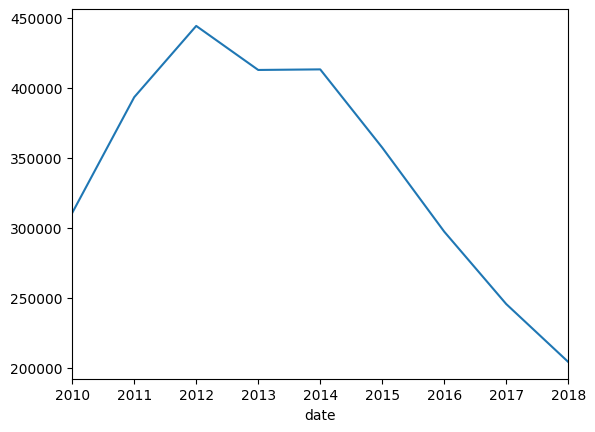

In [55]:
group = df['raw_row_number'].groupby(pd.Grouper(freq='Y')).agg('count').drop(index='2019-12-31')
print(group)
group.plot(y='raw_row_number',use_index=True)

## Does time of day affect arrest rate?

In [ ]:
## Need to create time data subset with time NaN rows removed

## How does drug activity change by time of day?

## Do most stops occur at night?

## Analyse the effect of weather?